In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys, os
import psutil
import subprocess
import GPUtil

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix
)
import wandb

# Enable script imports
sys.path.append(os.path.abspath(".."))
from scripts.result_logger import log_results

In [2]:
# Load the pre-preprocessed Social Media dataset

df = pd.read_csv("../data/social_clean.csv")
df = df.dropna(subset=["clean_text", "sentiment_label"])
df.head()

,sentiment_label,text,clean_text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david carr...
1,Negative,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...


In [3]:
# Splitting Data for Train/Val/Test (70-15-15 split)

X = df['clean_text']
y = df['sentiment_label']

# First split: Temp [Train+Val] (85%) + Test(15%)  
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

# Second split: Train(70%) + Val (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.1765,                                       # becoz 0.1765 × 85% ≈ 15%
    random_state=42, 
    stratify=y_temp
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (1117166,), Validation: (239442,), Test: (239402,)


In [4]:
# Drop NaNs again before saving

X_train = X_train.dropna()
X_val = X_val.dropna()
X_test = X_test.dropna()
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# Save splits for DL/LLM reuse
os.makedirs("../data/splits", exist_ok=True)

X_train.to_csv("../data/splits/X_train.csv", index=False)
X_val.to_csv("../data/splits/X_val.csv", index=False)
X_test.to_csv("../data/splits/X_test.csv", index=False)

y_train.to_csv("../data/splits/y_train.csv", index=False)
y_val.to_csv("../data/splits/y_val.csv", index=False)
y_test.to_csv("../data/splits/y_test.csv", index=False)

In [5]:
# Vectorization (TF-IDF)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Naive Bayes Model

In [6]:
# wandb Init

wandb.init(
    project="sentiment-analysis",
    name="NaiveBayes_Social",
    config={
        "model": "Naive Bayes",
        "dataset": "Sentiment140",
        "vectorizer": "TF-IDF",
        "features": 10000
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: smpandit (smpandit-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


message_loop has been closed
Traceback (most recent call last):
  File "/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/wandb/sdk/interface/router_sock.py", line 27, in _read_message
    return self._sock_client.read_server_response(timeout=1)
  File "/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/wandb/sdk/lib/sock_client.py", line 235, in read_server_response
    data = self._read_packet_bytes(timeout=timeout)
  File "/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/wandb/sdk/lib/sock_client.py", line 220, in _read_packet_bytes
    raise SockClientClosedError
wandb.sdk.lib.sock_client.SockClientClosedError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/wandb/sdk/interface/router.py", line 56, in message_loop
    msg = self._read_message()
  File "/home/smpa

In [7]:
# Train Naive Bayes Model

start_time = time.time()

nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

train_time = time.time() - start_time

In [8]:
# Validation Evaluation
y_val_pred_nb = nb_model.predict(X_val_vec)
print("\n Naive Bayes - Validation Set:")
print(classification_report(y_val, y_val_pred_nb))
val_acc = accuracy_score(y_val, y_val_pred_nb)
val_prec = precision_score(y_val, y_val_pred_nb, pos_label='Positive')
val_rec = recall_score(y_val, y_val_pred_nb, pos_label='Positive')
val_f1 = f1_score(y_val, y_val_pred_nb, pos_label='Positive')

# Test Evaluation
y_test_pred_nb = nb_model.predict(X_test_vec)
print("\n Naive Bayes - Test Set:")
print(classification_report(y_test, y_test_pred_nb))
acc = accuracy_score(y_test, y_test_pred_nb)
prec = precision_score(y_test, y_test_pred_nb, pos_label='Positive')
rec = recall_score(y_test, y_test_pred_nb, pos_label='Positive')
f1 = f1_score(y_test, y_test_pred_nb, pos_label='Positive')


 Naive Bayes - Validation Set:
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78    119762
    Positive       0.79      0.77      0.78    119680

    accuracy                           0.78    239442
   macro avg       0.78      0.78      0.78    239442
weighted avg       0.78      0.78      0.78    239442


 Naive Bayes - Test Set:
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78    119742
    Positive       0.79      0.77      0.78    119660

    accuracy                           0.78    239402
   macro avg       0.78      0.78      0.78    239402
weighted avg       0.78      0.78      0.78    239402



In [9]:
# Inference Time
 
start_inf = time.time()
_ = nb_model.predict(X_test_vec[:100])
inference_time = (time.time() - start_inf) / 100  # average per sample

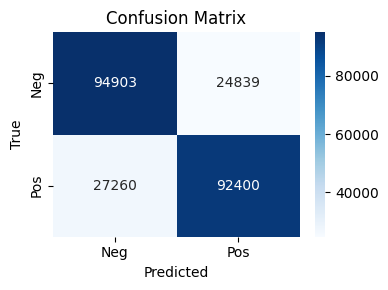

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_nb, labels=['Negative', 'Positive'])
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("nb_confusion_matrix.png")

In [11]:
# System Stats

cpu_usage = psutil.cpu_percent(interval=1)
mem_usage = psutil.virtual_memory().percent
gpu = GPUtil.getGPUs()[0]
power = subprocess.check_output([
    "nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"
]).decode("utf-8").strip()

In [14]:
# Log results to  result_logger.py & wandb Logs

log_results(
    model_name="Naive Bayes",
    dataset_name="Social Media",
    accuracy=acc,
    precision=prec,
    recall=rec,
    f1=f1,
    tuning_time=None,
    train_time=train_time,
    inference_time=inference_time,
    latency=inference_time * 1000,
    cpu_usage=cpu_usage,
    mem_usage=mem_usage,
    gpu_usage=gpu.load * 100,
    gpu_mem_usage=gpu.memoryUtil * 100,
    gpu_temp=gpu.temperature,
    power=float(power),
    num_features=10000,
    hyperparams="default",
)

wandb.log({
    "Validation Accuracy": val_acc, 
    "Validation Precision": val_prec,
    "Validation Recall": val_rec, 
    "Validation F1 Score": val_f1,
    "Test Accuracy": acc,
    "Test Precision": prec,
    "Test Recall": rec,
    "Test F1 Score": f1,
    "Training Time (s)": train_time,
    "Inference Time per Sample (s)": inference_time,
    "Latency (ms)": inference_time * 1000,
    "CPU Usage (%)": cpu_usage,
    "Memory Usage (%)": mem_usage,
    "GPU Usage (%)": gpu.load * 100,
    "GPU Memory Usage (%)": gpu.memoryUtil * 100,
    "GPU Temp (C)": gpu.temperature,
    "Power Consumption (W)": float(power),
    "Confusion Matrix": wandb.Image("nb_confusion_matrix.png")
})

wandb.finish()

Logged: Naive Bayes on Social Media to ../results/results.csv


CPU Usage (%),▁
GPU Memory Usage (%),▁
GPU Temp (C),▁
GPU Usage (%),▁
Inference Time per Sample (s),▁
Latency (ms),▁
Memory Usage (%),▁
Power Consumption (W),▁
Test Accuracy,▁
Test F1 Score,▁
Test Precision,▁


# SVM Model

In [3]:
# Load split data
X_train = pd.read_csv("../data/splits/X_train.csv")["clean_text"]
X_val   = pd.read_csv("../data/splits/X_val.csv")["clean_text"]
X_test  = pd.read_csv("../data/splits/X_test.csv")["clean_text"]

y_train = pd.read_csv("../data/splits/y_train.csv")["sentiment_label"]
y_val   = pd.read_csv("../data/splits/y_val.csv")["sentiment_label"]
y_test  = pd.read_csv("../data/splits/y_test.csv")["sentiment_label"]

In [4]:
# Vectorization (TF-IDF)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [5]:
# Hyperparameter tuning

print("\n Hyperparameter tuning for SVM...")
best_accuracy = 0
best_C = 1.0

start_tune = time.time()

for C in [0.1, 0.5, 1.0, 2.0, 5.0]:
    svm_model = LinearSVC(C=C, max_iter=1000)
    svm_model.fit(X_train_vec, y_train)

    val_pred = svm_model.predict(X_val_vec)
    
    acc = accuracy_score(y_val, val_pred)
    print(f"C={C} → Validation Accuracy: {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_C = C

tuning_time = time.time() - start_tune

print(f"\n Best C: {best_C} with Validation Accuracy: {best_accuracy:.4f}")


 Hyperparameter tuning for SVM...
C=0.1 → Validation Accuracy: 0.8042
C=0.5 → Validation Accuracy: 0.8044
C=1.0 → Validation Accuracy: 0.8044
C=2.0 → Validation Accuracy: 0.8044
C=5.0 → Validation Accuracy: 0.8043

 Best C: 0.5 with Validation Accuracy: 0.8044


In [6]:
# wandb Init

wandb.init(
    project="sentiment-analysis", 
    name="SVM_Social",
    config={
        "model": "SVM", 
        "dataset": "Sentiment140",
        "vectorizer": "TF-IDF",
        "features": 10000,
        "C": best_C
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: smpandit (smpandit-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Train SVM Model

start = time.time()

svm_model = LinearSVC(C=best_C, max_iter=1000)
svm_model.fit(X_train_vec, y_train)

train_time = time.time() - start

In [8]:
# Validation Evaluation
y_val_pred_svm = svm_model.predict(X_val_vec)
print("\n SVM - Validation Set:")
print(classification_report(y_val, y_val_pred_svm))
val_acc = accuracy_score(y_val, y_val_pred_svm)
val_prec = precision_score(y_val, y_val_pred_svm, pos_label='Positive')
val_rec = recall_score(y_val, y_val_pred_svm, pos_label='Positive')
val_f1 = f1_score(y_val, y_val_pred_svm, pos_label='Positive')

# Test Evaluation
y_pred = svm_model.predict(X_test_vec)
print("\n SVM - Test Set:")
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label='Positive')
rec = recall_score(y_test, y_pred, pos_label='Positive')
f1 = f1_score(y_test, y_pred, pos_label='Positive')


 SVM - Validation Set:
              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80    119762
    Positive       0.79      0.82      0.81    119680

    accuracy                           0.80    239442
   macro avg       0.80      0.80      0.80    239442
weighted avg       0.80      0.80      0.80    239442


 SVM - Test Set:
              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80    119742
    Positive       0.80      0.82      0.81    119660

    accuracy                           0.80    239402
   macro avg       0.80      0.80      0.80    239402
weighted avg       0.80      0.80      0.80    239402



In [9]:
# Inference Time

start_inf = time.time()
_ = svm_model.predict(X_test_vec[:100])
infer_time = (time.time() - start_inf) / 100

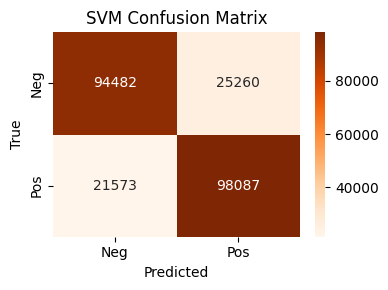

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['Negative', 'Positive'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("svm_confusion_matrix.png")

In [11]:
# System Stats

cpu_usage = psutil.cpu_percent(interval=1)
mem_usage = psutil.virtual_memory().percent
gpu = GPUtil.getGPUs()[0]
power = subprocess.check_output([
    "nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"
]).decode("utf-8").strip()

In [12]:
# Log results to  result_logger.py & wandb Logs

log_results(
    model_name="SVM",
    dataset_name="Social Media",
    accuracy=acc,
    precision=prec,
    recall=rec,
    f1=f1,
    tuning_time=tuning_time,
    train_time=train_time,
    inference_time=infer_time,
    latency=infer_time * 1000,
    cpu_usage=cpu_usage,
    mem_usage=mem_usage,
    gpu_usage=gpu.load * 100,
    gpu_mem_usage=gpu.memoryUtil * 100,
    gpu_temp=gpu.temperature,
    power=float(power),
    num_features=10000,
    hyperparams=f"C={best_C}"
)

wandb.log({
    "Validation Accuracy": val_acc, 
    "Validation Precision": val_prec,
    "Validation Recall": val_rec, 
    "Validation F1 Score": val_f1,
    "Test Accuracy": acc, 
    "Test Precision": prec, 
    "Test Recall": rec, 
    "Test F1 Score": f1,
    "Tuning Time (s)": tuning_time,
    "Training Time (s)": train_time,
    "Inference Time per Sample (s)": infer_time,
    "Latency (ms)": infer_time * 1000,
    "CPU Usage (%)": cpu_usage,
    "Memory Usage (%)": mem_usage,
    "GPU Usage (%)": gpu.load * 100,
    "GPU Memory Usage (%)": gpu.memoryUtil * 100,
    "GPU Temp (C)": gpu.temperature,
    "Power Consumption (W)": float(power),
    "Confusion Matrix": wandb.Image("svm_confusion_matrix.png")
})

wandb.finish()

Logged: SVM on Social Media to ../results/results.csv


CPU Usage (%),▁
GPU Memory Usage (%),▁
GPU Temp (C),▁
GPU Usage (%),▁
Inference Time per Sample (s),▁
Latency (ms),▁
Memory Usage (%),▁
Power Consumption (W),▁
Test Accuracy,▁
Test F1 Score,▁
Test Precision,▁
